# Evolution of urban patterns: urban morphology as an open reproducible data science

## Summary statistics

This is the second notebook in a sequence of three. The notebook summarise morphometric data obtained in the previous notebook on the basis of historical periods.

It requires `data/case_studies.csv` input with origins of case studies and data generated by the first notebook.

Date: May 17, 2021

---

We start with the import of libraries used in this notebook.

In [1]:
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import pathlib
from palettable.wesanderson import Moonrise5_6

Using seaborn we can specify global settings for all matplotlib-based plots.

In [2]:
sns.set()

We will need the original input of our case studies as we needed in the first notebook.

In [3]:
cases = pd.read_csv("data/case_studies3.csv")
cases

,case,period,origin
0,Connaught Place,pre-industrial,"(77.2194442012068, 28.63264672036609)"
1,Nehru Place,pre-industrial,"(77.25246542282517, 28.54930101761747)"
2,Baner gaon,pre-industrial,"(73.78743391399972, 18.559120436182322)"
3,Siripuram,pre-industrial,"(83.31672292288425, 17.719918874948867)"
4,Manikonda,pre-industrial,"(78.37094172770058, 17.411693315316967)"
5,T Nagar,pre-industrial,"(80.23817967215369, 13.043225604625261)"
6,Cuffe Parade,pre-industrial,"(72.82000253375675, 18.91442395337802)"
7,Ballard Estate,pre-industrial,"(72.83688268053827, 18.936504427534746)"
8,Indiranagar,industrial,"(77.64059073182727, 12.975796346358312)"
9,Electronic City,industrial,"(77.67473906976637, 12.836071363558153)"


It will be easier to use `case` column as an index.

In [4]:
cases = cases.set_index("case")

Using `glob` library, we get a list of all GeoPackages created in the first notebook.

In [5]:
files = glob.glob("data/*gpkg")

We need to generate a single DataFrame with all the results of all case studies combined. Let's prepare an empty DataFrame for that.

In [6]:
data = pd.DataFrame()

Now we loop through the list of GeoPackages and:
1. Read the file.
2. Select only those geometries within 400 m buffer around the origin. That way we minimise potential edge effect affecting the results.
3. Store period and case name within the DataFrame and append it together with morphometric data from GPKG to our `data` DataFrame.

In [7]:
for f in files:
    tessellation = gpd.read_file(f, layer="tessellation")
    case = pathlib.Path(f).stem
    coords = cases.origin.loc[case]
    buffer = gpd.GeoSeries([Point(tuple(map(float, coords[1:-1].split(', '))))], crs=4326).to_crs(tessellation.crs).buffer(400)
    tessellation['period'] = cases.period.loc[case]
    tessellation['case'] = case
    casegdf = tessellation[tessellation.centroid.within(buffer.iloc[0])]
    data = data.append(casegdf.drop(columns=["uID", "nID", "mm_len", "node_start", "node_end", "nodeID", "geometry"]))

Since `period` is an ordered categorical column, let's encode it as such.

In [9]:
data['period'] = pd.Categorical(data['period'], categories=['pre-industrial', 'industrial', 'garden city', 'modernist', 'neo-traditional', 'informal'], ordered=True)

Now we can sort the `data` based on the `period` in a way which follows the time.

In [10]:
data = data.sort_values('period').reset_index(drop=True)

For our figures, we want `paper` context, `whitegrid` style and `palettable`'s `Moonrise5_6` color palette.

In [11]:
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette(Moonrise5_6.hex_colors)

It is better to rename final labels to nicers ones, so let's prepare a dictionary for that.

In [12]:
labels = {
    "cell_area": "Area of a tessellation cell [m]",
    "car": "Covered area ratio",
    "blg_area": "Area of a building footprint [m]",
    "wall": "Length of a perimeter wall [m]",
    "adjacency": "Building adjacency",
    "neighbour_distance": "Mean neighbor distance between buildings [m]",
    "length": "Length of a street segment [m]",
    "linearity": "Linearity of a street segment",
    "width": "Width of a street profile [m]",
    "width_deviation": "Width deviation of a street profile [m]",
    "openness": "Openness of a street profile",
    "meshedness": "Meshedness of a street network",
}

Now we loop through all morphometric characters and create box plots for each city, once with normal y axis and once with log y axis.

In [13]:
for ch in data.columns.drop(['case', 'period']):
    plt.figure(figsize=(12, 8))
    boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
    boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
    boxen.set_ylabel(labels[ch])
    boxen.set_xlabel("Case study")
    sns.despine()
    plt.legend(loc="lower left", borderaxespad=0., ncol=6, frameon=False)
    plt.savefig(f"figures/{ch}_all_normal.png", bbox_inches="tight")
    plt.close("all")
    
    plt.figure(figsize=(12, 8))
    boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
    boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
    boxen.set_ylabel(labels[ch])
    boxen.set_xlabel("Case study")
    boxen.set_yscale("log")
    sns.despine()
    plt.legend(loc="lower left", borderaxespad=0., ncol=6, frameon=False)
    plt.savefig(f"figures/{ch}_all_log.png", bbox_inches="tight")
    plt.close("all")

We can also create box plots for each character grouped by period.

In [14]:
for ch in data.columns.drop(['case', 'period']):
    plt.figure(figsize=(12, 8))
    box = sns.boxplot(x="period", y=ch,dodge=False, data=data, showfliers=False)
    box.set_ylabel(labels[ch])
    box.set_xlabel("Historical period")
    sns.despine()
    plt.savefig(f"figures/{ch}_grouped_normal.png", bbox_inches="tight")
    plt.close("all")
    
    plt.figure(figsize=(12, 8))
    box = sns.boxplot(x="period", y=ch,dodge=False, data=data, showfliers=False)
    box.set_ylabel(labels[ch])
    box.set_xlabel("Historical period")
    box.set_yscale("log")
    sns.despine()
    plt.savefig(f"figures/{ch}_grouped_log.png", bbox_inches="tight")
    plt.close("all")

To report median values per character and period, we can create a grouped DataFrame.

In [15]:
grouper = data.drop(columns='case').groupby('period')
medians = grouper.median()
medians = medians.rename(columns=labels)
med = medians.T.round(2)
med

period,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
Area of a tessellation cell [m],1042.56,404.37,644.40,435.06,404.51,493.61
Covered area ratio,0.27,0.39,0.20,0.35,0.31,0.33
Area of a building footprint [m],260.71,155.19,115.04,139.38,122.24,153.97
Length of a perimeter wall [m],70.80,51.68,44.44,49.07,46.93,52.01
Building adjacency,1.00,1.00,1.00,1.00,1.00,1.00
Mean neighbor distance between buildings [m],15.85,8.09,13.95,10.16,8.31,10.63
Length of a street segment [m],128.54,119.95,95.04,108.34,107.40,85.84
Linearity of a street segment,1.00,1.00,1.00,1.00,1.00,1.00
Width of a street profile [m],22.99,16.75,20.48,13.73,16.82,18.84
Width deviation of a street profile [m],3.87,4.51,5.01,4.25,5.27,4.50


It may also be useful to report interquartile range to illustrate the spread of each distribution.

In [16]:
iqr = (grouper.quantile(.75).values - grouper.quantile(.25))
iqr = iqr.rename(columns=labels)
iq = iqr.T.round(2)
iq

period,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
Area of a tessellation cell [m],1733.99,554.94,976.49,951.03,863.87,660.08
Covered area ratio,0.24,0.21,0.21,0.28,0.22,0.20
Area of a building footprint [m],342.44,175.11,152.79,118.44,212.40,121.47
Length of a perimeter wall [m],55.03,29.48,29.44,68.39,39.87,18.86
Building adjacency,0.02,0.00,0.00,0.01,0.00,0.00
Mean neighbor distance between buildings [m],16.49,7.43,16.30,25.54,11.17,9.35
Length of a street segment [m],128.96,104.16,61.16,87.62,104.53,78.39
Linearity of a street segment,0.01,0.00,0.01,0.00,0.01,0.00
Width of a street profile [m],13.89,9.64,17.28,13.50,10.62,7.34
Width deviation of a street profile [m],2.51,2.45,3.12,2.94,1.95,2.80


We want to report both in the same table.

In [17]:
med.astype('str') + ' (' + iq.astype('str') + ')'

period,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
Area of a tessellation cell [m],1042.56 (1733.99),404.37 (554.94),644.4 (976.49),435.06 (951.03),404.51 (863.87),493.61 (660.08)
Covered area ratio,0.27 (0.24),0.39 (0.21),0.2 (0.21),0.35 (0.28),0.31 (0.22),0.33 (0.2)
Area of a building footprint [m],260.71 (342.44),155.19 (175.11),115.04 (152.79),139.38 (118.44),122.24 (212.4),153.97 (121.47)
Length of a perimeter wall [m],70.8 (55.03),51.68 (29.48),44.44 (29.44),49.07 (68.39),46.93 (39.87),52.01 (18.86)
Building adjacency,1.0 (0.02),1.0 (0.0),1.0 (0.0),1.0 (0.01),1.0 (0.0),1.0 (0.0)
Mean neighbor distance between buildings [m],15.85 (16.49),8.09 (7.43),13.95 (16.3),10.16 (25.54),8.31 (11.17),10.63 (9.35)
Length of a street segment [m],128.54 (128.96),119.95 (104.16),95.04 (61.16),108.34 (87.62),107.4 (104.53),85.84 (78.39)
Linearity of a street segment,1.0 (0.01),1.0 (0.0),1.0 (0.01),1.0 (0.0),1.0 (0.01),1.0 (0.0)
Width of a street profile [m],22.99 (13.89),16.75 (9.64),20.48 (17.28),13.73 (13.5),16.82 (10.62),18.84 (7.34)
Width deviation of a street profile [m],3.87 (2.51),4.51 (2.45),5.01 (3.12),4.25 (2.94),5.27 (1.95),4.5 (2.8)


Following cells pick individual boxplots (same we created above) and generate combined figures used in the final paper.

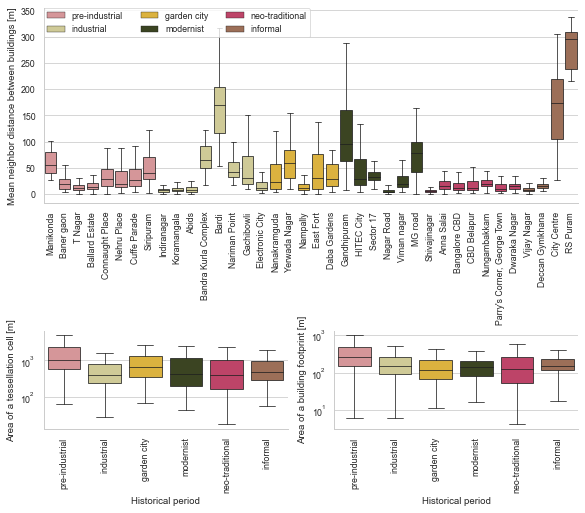

In [18]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='neighbour_distance', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['neighbour_distance'])
top.set_xlabel("")

sns.boxplot(x="period", y='cell_area',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['cell_area'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)
left.set_yscale("log")

sns.boxplot(x="period", y='blg_area',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['blg_area'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
right.set_yscale("log")
sns.despine()

top.legend(loc="upper left", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_1.png", bbox_inches="tight", dpi=300)

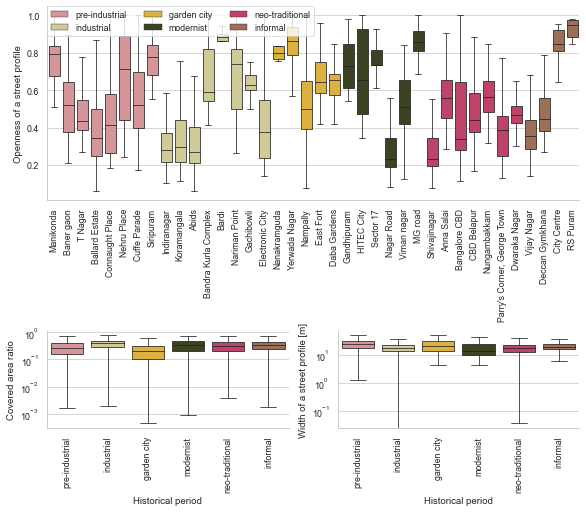

In [19]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='openness', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['openness'])
top.set_xlabel("")

sns.boxplot(x="period", y='car',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['car'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)
left.set_yscale("log")

sns.boxplot(x="period", y='width',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['width'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
right.set_yscale("log")
sns.despine()

top.legend(loc="upper left", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_2.png", bbox_inches="tight", dpi=300)

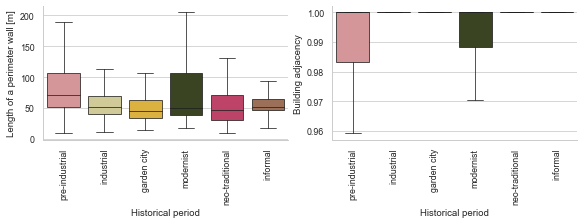

In [20]:
fig = plt.figure(figsize=(8, 3), constrained_layout=True)
gs = fig.add_gridspec(1, 2)
left = fig.add_subplot(gs[0, 0])
right = fig.add_subplot(gs[0, 1])

sns.boxplot(x="period", y='wall',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['wall'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)

sns.boxplot(x="period", y='adjacency',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['adjacency'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
sns.despine()

plt.savefig(f"figures/results_3.png", bbox_inches="tight", dpi=300)

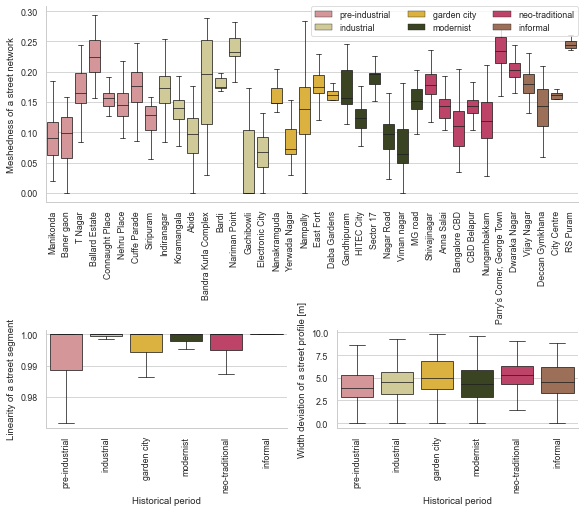

In [21]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='meshedness', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['meshedness'])
top.set_xlabel("")

sns.boxplot(x="period", y='linearity',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['linearity'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)

sns.boxplot(x="period", y='width_deviation',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['width_deviation'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
sns.despine()

top.legend(loc="upper right", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_4.png", bbox_inches="tight", dpi=300)

## Statistical comparison

We also want to compare similarity of distributions statistically, not only visually. We use Kruskal–Wallis one-way analysis of variance and Pairwise Mann–Whitney *U* test for that.

In [22]:
from scipy import stats

data = data.set_index('case')

In [23]:
data = data.rename(columns=labels)

### Kruskal–Wallis one-way analysis of variance

Kruskal–Wallis one-way analysis of variance is chosen as a non-parametric equivalent of ANOVA due to skewed distributions of underlying data.

In [24]:
kruskal = pd.DataFrame()
for col in data.columns.drop("period"):
    H, p = stats.kruskal(*[data[data.period == per][col] for per in data.period.cat.categories])
    kruskal.loc[col, 'H'] = H
    kruskal.loc[col, 'p'] = p

In [25]:
kruskal

,H,p
Area of a tessellation cell [m],917.811332,3.716801e-196
Covered area ratio,855.631002,1.063798e-182
Area of a building footprint [m],696.186732,3.279061e-148
Length of a perimeter wall [m],704.013755,6.658790e-150
Building adjacency,848.964970,2.946364e-181
Mean neighbor distance between buildings [m],814.156865,1.001298e-173
Length of a street segment [m],331.724076,1.502928e-69
Linearity of a street segment,390.765691,2.899557e-82
Width of a street profile [m],721.149510,1.312308e-153
Width deviation of a street profile [m],696.868079,2.335781e-148


The results indicate that the distributions of morphometric values obtained from samples from different historical periods cannot be considered the same.

### Pairwise Mann–Whitney _U_ test

In [26]:
from itertools import product

mann_whitney_U = {}
mann_whitney_p = {}
for col in data.columns.drop("period"):
    df_u = pd.DataFrame(columns=data.period.cat.categories, index=data.period.cat.categories)
    df_p = pd.DataFrame(columns=data.period.cat.categories, index=data.period.cat.categories)
    for a, b in product(data.period.cat.categories, repeat=2):
        if pd.isna(df_u.loc[b, a]):
            U, p = stats.mannwhitneyu(data[data.period == a][col], data[data.period == b][col])
            df_u.loc[a, b] = U
            df_p.loc[a, b] = p
        else:
            df_u.loc[a, b] = df_u.loc[b, a]
            df_p.loc[a, b] = df_p.loc[b, a]
            
    mann_whitney_U[col] = df_u
    mann_whitney_p[col] = df_p

In [27]:
for col in data.columns.drop("period"):
    if not (mann_whitney_p[col] > .05).sum().sum() == 6:
        print(f"{col}")

Area of a tessellation cell [m]
Covered area ratio
Area of a building footprint [m]
Length of a perimeter wall [m]
Building adjacency
Mean neighbor distance between buildings [m]
Length of a street segment [m]
Linearity of a street segment
Width of a street profile [m]
Openness of a street profile
Meshedness of a street network


In three cases, `Building adjacency`, `Linearity of a street segment`, and `Width deviation of a street profile`, Mann–Whitney _U_ is not significant (`p < 0.05`) in all pairwise cases.

In [28]:
mann_whitney_p['Building adjacency'] > .05

,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
pre-industrial,True,False,False,True,False,False
industrial,False,True,True,False,False,False
garden city,False,True,True,False,False,False
modernist,True,False,False,True,False,False
neo-traditional,False,False,False,False,True,False
informal,False,False,False,False,False,True


In [29]:
mann_whitney_p['Building adjacency'].round(3)

,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
pre-industrial,1.0,0.0,0.0,0.068911,0.0,0.0
industrial,0.0,1.0,0.835986,0.0,0.0,0.0
garden city,0.0,0.835986,1.0,0.0,0.0,0.0
modernist,0.068911,0.0,0.0,1.0,0.0,0.0
neo-traditional,0.0,0.0,0.0,0.0,1.0,0.00388
informal,0.0,0.0,0.0,0.0,0.00388,1.0


In the case of `Building adjacency`, the distributions of values in Garden city and Modernist periods cannot be considered significantly different. 

In [30]:
mann_whitney_p['Linearity of a street segment'] > .05

,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
pre-industrial,True,False,False,False,False,False
industrial,False,True,False,False,False,False
garden city,False,False,True,True,True,False
modernist,False,False,True,True,True,False
neo-traditional,False,False,True,True,True,False
informal,False,False,False,False,False,True


In [31]:
mann_whitney_p['Linearity of a street segment'].round(3)

,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
pre-industrial,1.0,0.000015,0.000245,0.004818,0.009402,0.0
industrial,0.000015,1.0,0.0,0.0,0.0,0.0
garden city,0.000245,0.0,1.0,0.219432,0.291905,0.0
modernist,0.004818,0.0,0.219432,1.0,0.542148,0.0
neo-traditional,0.009402,0.0,0.291905,0.542148,1.0,0.0
informal,0.0,0.0,0.0,0.0,0.0,1.0


In the case of `Linearity of a street segment`, the distributions of values in Garden city and Modernist periods cannot be considered significantly different.

In [32]:
mann_whitney_p['Width deviation of a street profile [m]'] > .05

,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
pre-industrial,True,False,False,False,False,False
industrial,False,True,False,False,False,False
garden city,False,False,True,False,False,False
modernist,False,False,False,True,False,False
neo-traditional,False,False,False,False,True,False
informal,False,False,False,False,False,True


In [33]:
mann_whitney_p['Width deviation of a street profile [m]'].round(3)

,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
pre-industrial,1.0,0.0,0.0,0.002552,0.0,0.0
industrial,0.0,1.0,0.0,0.002509,0.0,0.00194
garden city,0.0,0.0,1.0,0.0,0.003897,0.000001
modernist,0.002552,0.002509,0.0,1.0,0.0,0.0
neo-traditional,0.0,0.0,0.003897,0.0,1.0,0.0
informal,0.0,0.00194,0.000001,0.0,0.0,1.0


In the case of `Width deviation of a street profile`, the distributions of values in Pre-industrial and Modernist periods cannot be considered significantly different.